# Train Word2Vec with gensim & application of embeddings in document similarity

## Install required packages

In [1]:
# scipy issue with gensim
# https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-gensim

!pip install scipy==1.10.1 numpy gensim scikit-learn matplotlib spacy lxml
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 16.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Import required packages

In [20]:
# Import necessary libraries
import re
import string
import glob
from tqdm import tqdm

import gensim
from gensim.models import Word2Vec

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")

## Define Tokenizer

In [3]:
def tokenize(text) -> list:
    """
    Tokenize text and return a non-unique list of tokenized words
    found in the text. 
      1. Normalize to lowercase. Strip punctuation, numbers, and `\r`, `\n`\, `\t`.
      2. Replace multiple spaces for a single space.
      3. Tokenize with spacy.
      4. Remove stopwords with spacy.
      5. Remove tokens with len <= 2
      6. Apply lemmatization to words using spacy.
    """
    text = text.lower()
    text = re.sub('[' + string.punctuation + '0-9\\r\\t\\n\\*]', ' ', text)
    # your code here
    text = re.sub(' +', ' ', text)
    tokens = [token.lemma_ for token in nlp(text) if len(token) > 2 and not token.is_stop]
    return tokens

## Load job description dataset

In [4]:
# Path to the job descriptions
all_files = glob.glob("data/*.csv")

# Load job description data
df = []

# Loop through each CSV file, read it into a DataFrame, and append it to the list
for filename in all_files:
    _df = pd.read_csv(filename)
    df.append(_df)

df = pd.concat(df, ignore_index=True)
valid_descriptions = df[~df['description'].isna()]['description']

## Tokenize the descriptions

In [6]:
# Tokenize job descriptions by spacy
tokenized_descriptions = []
for description in tqdm(valid_descriptions):
    tokens = tokenize(description)
    tokenized_descriptions.append(tokens)

  0%|          | 0/900 [00:00<?, ?it/s]

100%|██████████| 900/900 [00:59<00:00, 15.08it/s]


In [7]:
# Train Word2Vec model
model = Word2Vec(tokenized_descriptions, vector_size=100, window=5, min_count=1, workers=12)
trained_word_count, raw_word_count = model.train(tokenized_descriptions, total_examples=len(tokenized_descriptions), epochs=10)

## Plot tsne representation of word embeddings around the target word "Python"

In [8]:
# Visualize word embeddings using t-SNE
def tsne_plot(model, target_word, k=100):
    labels = []
    wordvecs = []

    similarity_to_target_word = []
    for word in tqdm(model.wv.key_to_index):
        similarity = model.wv.similarity(word, target_word)
        similarity_to_target_word.append((word, similarity))
    top_similar_words = [pair[0] for pair in sorted(similarity_to_target_word, key=lambda x: x[1], reverse=True)[:k]]

    for word in top_similar_words:
        if word in model.wv.key_to_index:
            wordvecs.append(model.wv[word])
            labels.append(word)

    tsne_model = TSNE(perplexity=2, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(wordvecs))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        if labels[i] == target_word:
            plt.scatter(x[i], y[i], s=500)
        else:
            plt.scatter(x[i], y[i], s=30)
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.title(f"top-{k} similar embeddings of words with that of target word ({target_word})")
    plt.show()

## Train the word2vec model and visualize

Try different set of hyperparameters during model training.
To visualize proper amount of words in t-SNE plot, I select 100 most similar words based on word embeddings with the word "python"

100%|██████████| 8375/8375 [00:00<00:00, 201453.79it/s]


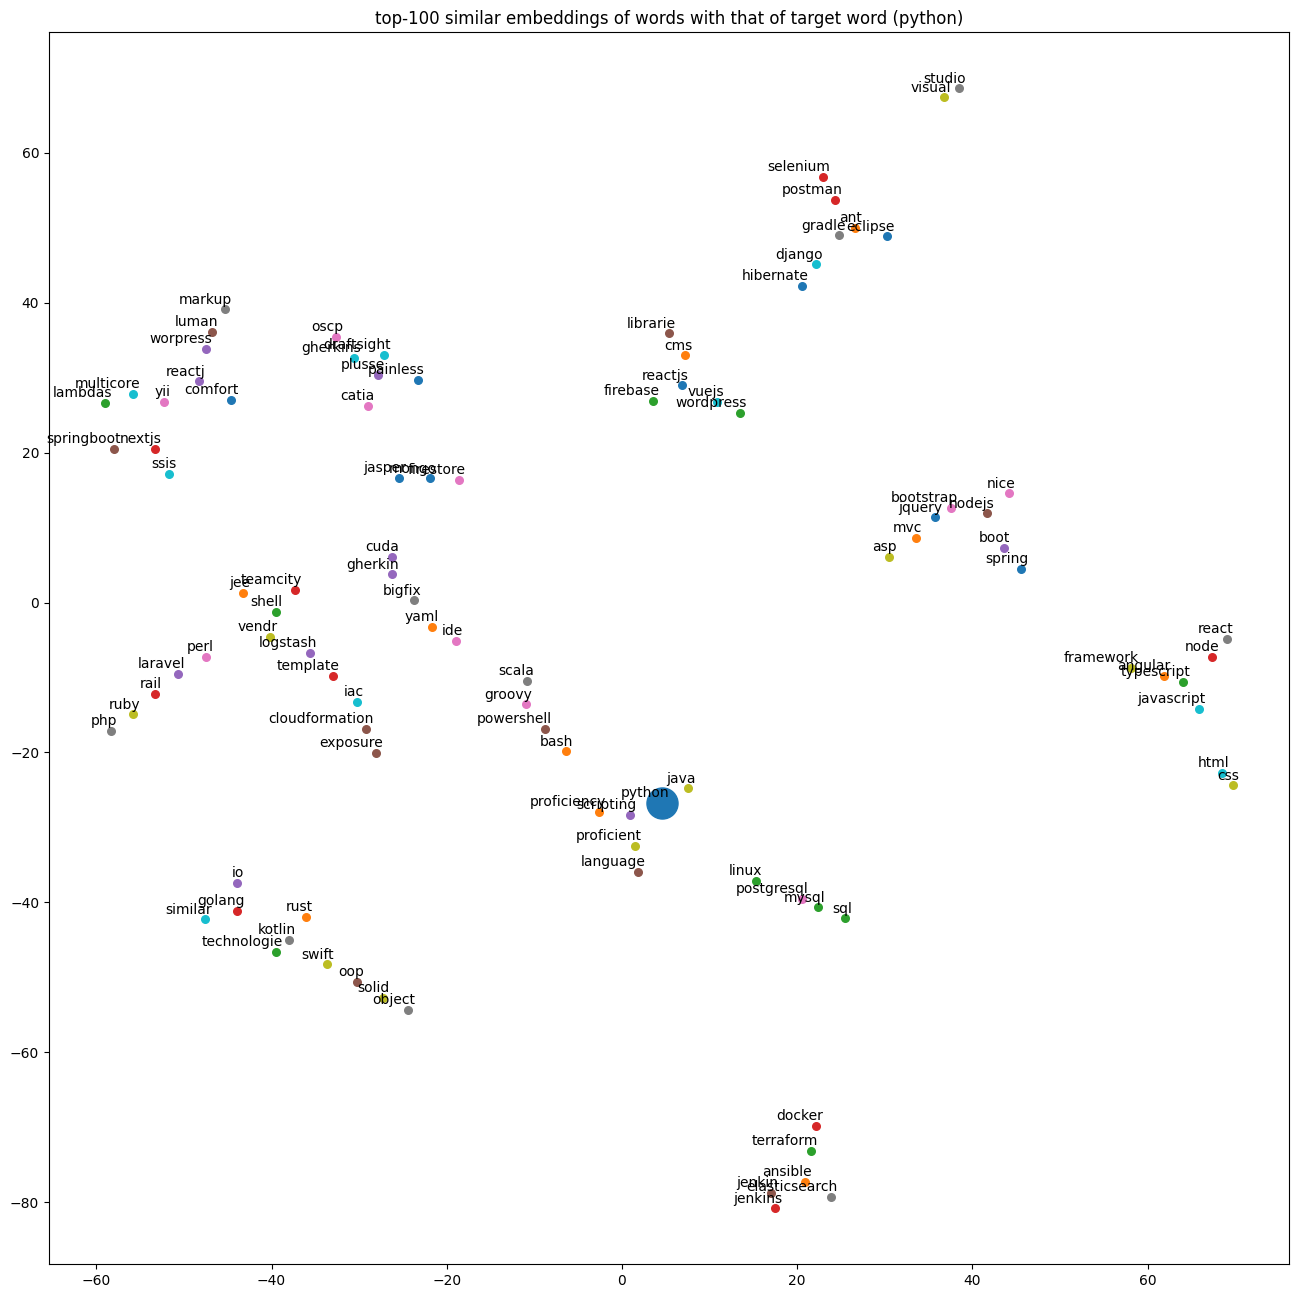

In [32]:
model = Word2Vec(tokenized_descriptions, vector_size=100, window=5, min_count=1, workers=12)
trained_word_count, raw_word_count = model.train(tokenized_descriptions, total_examples=len(tokenized_descriptions), epochs=10)

k = 100
target_word = "python"
tsne_plot(model, target_word, k)

100%|██████████| 8375/8375 [00:00<00:00, 159213.60it/s]


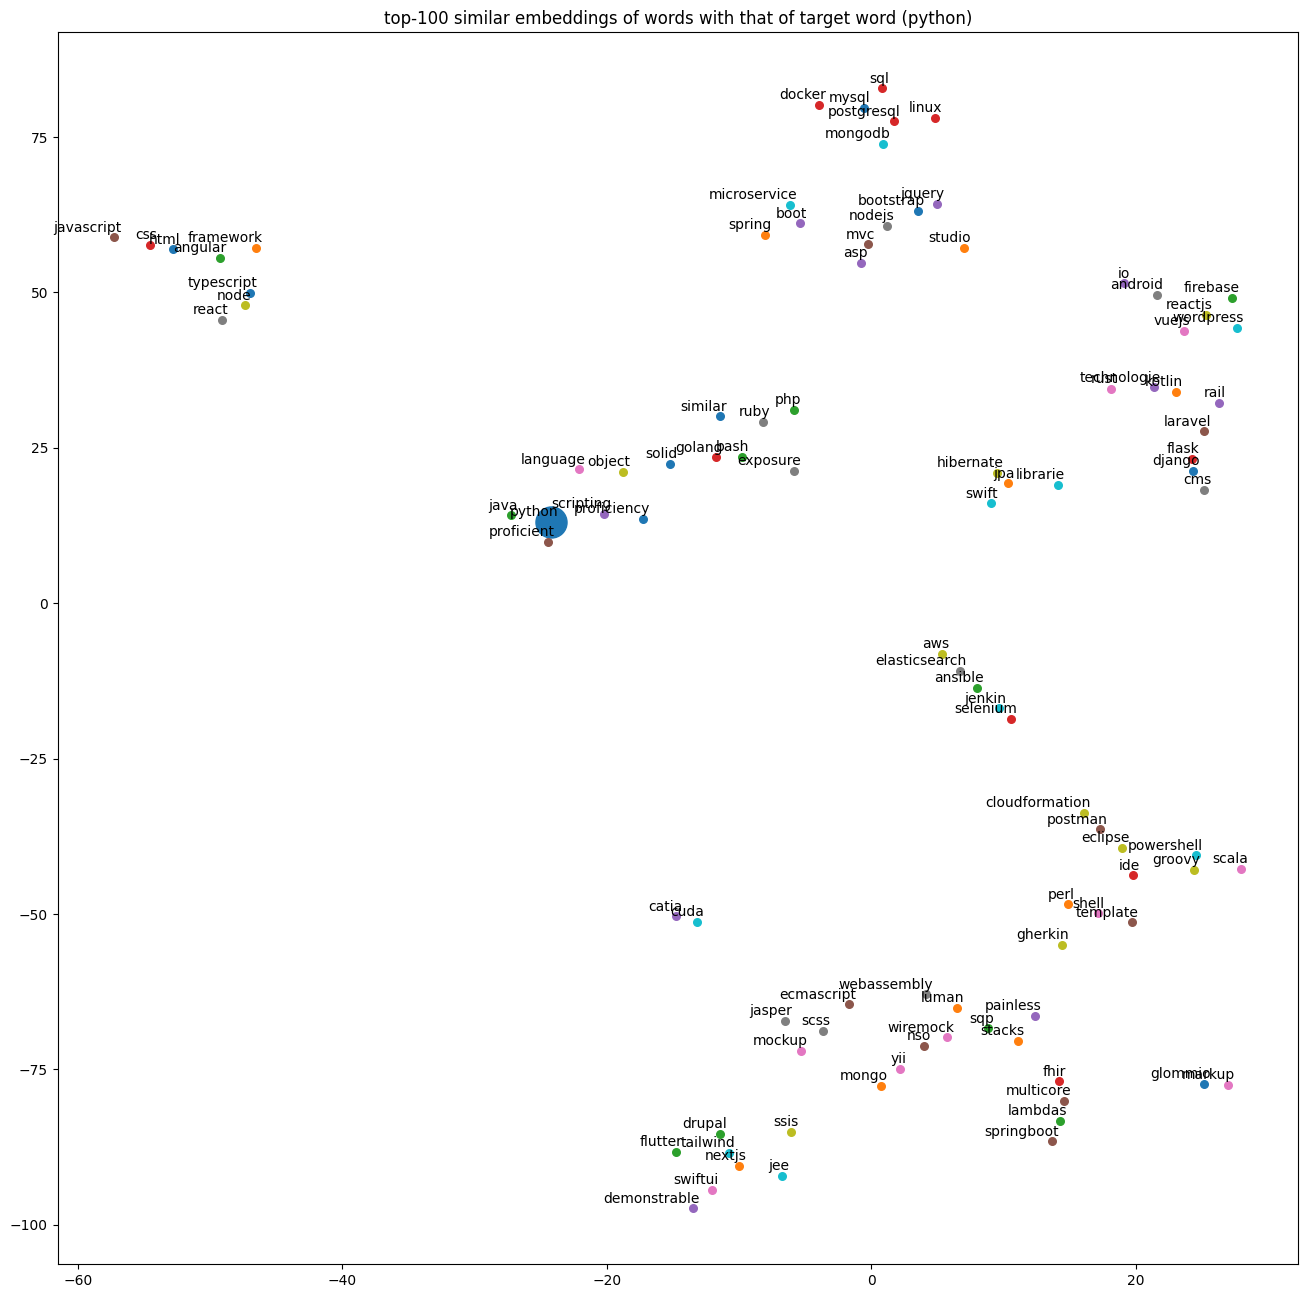

In [33]:
# Train Word2Vec model with more vector size (100 -> 500)
model = Word2Vec(tokenized_descriptions, vector_size=500, window=5, min_count=1, workers=12)
trained_word_count, raw_word_count = model.train(tokenized_descriptions, total_examples=len(tokenized_descriptions), epochs=10)

k = 100
target_word = "python"
tsne_plot(model, target_word, k)

100%|██████████| 8375/8375 [00:00<00:00, 215479.77it/s]


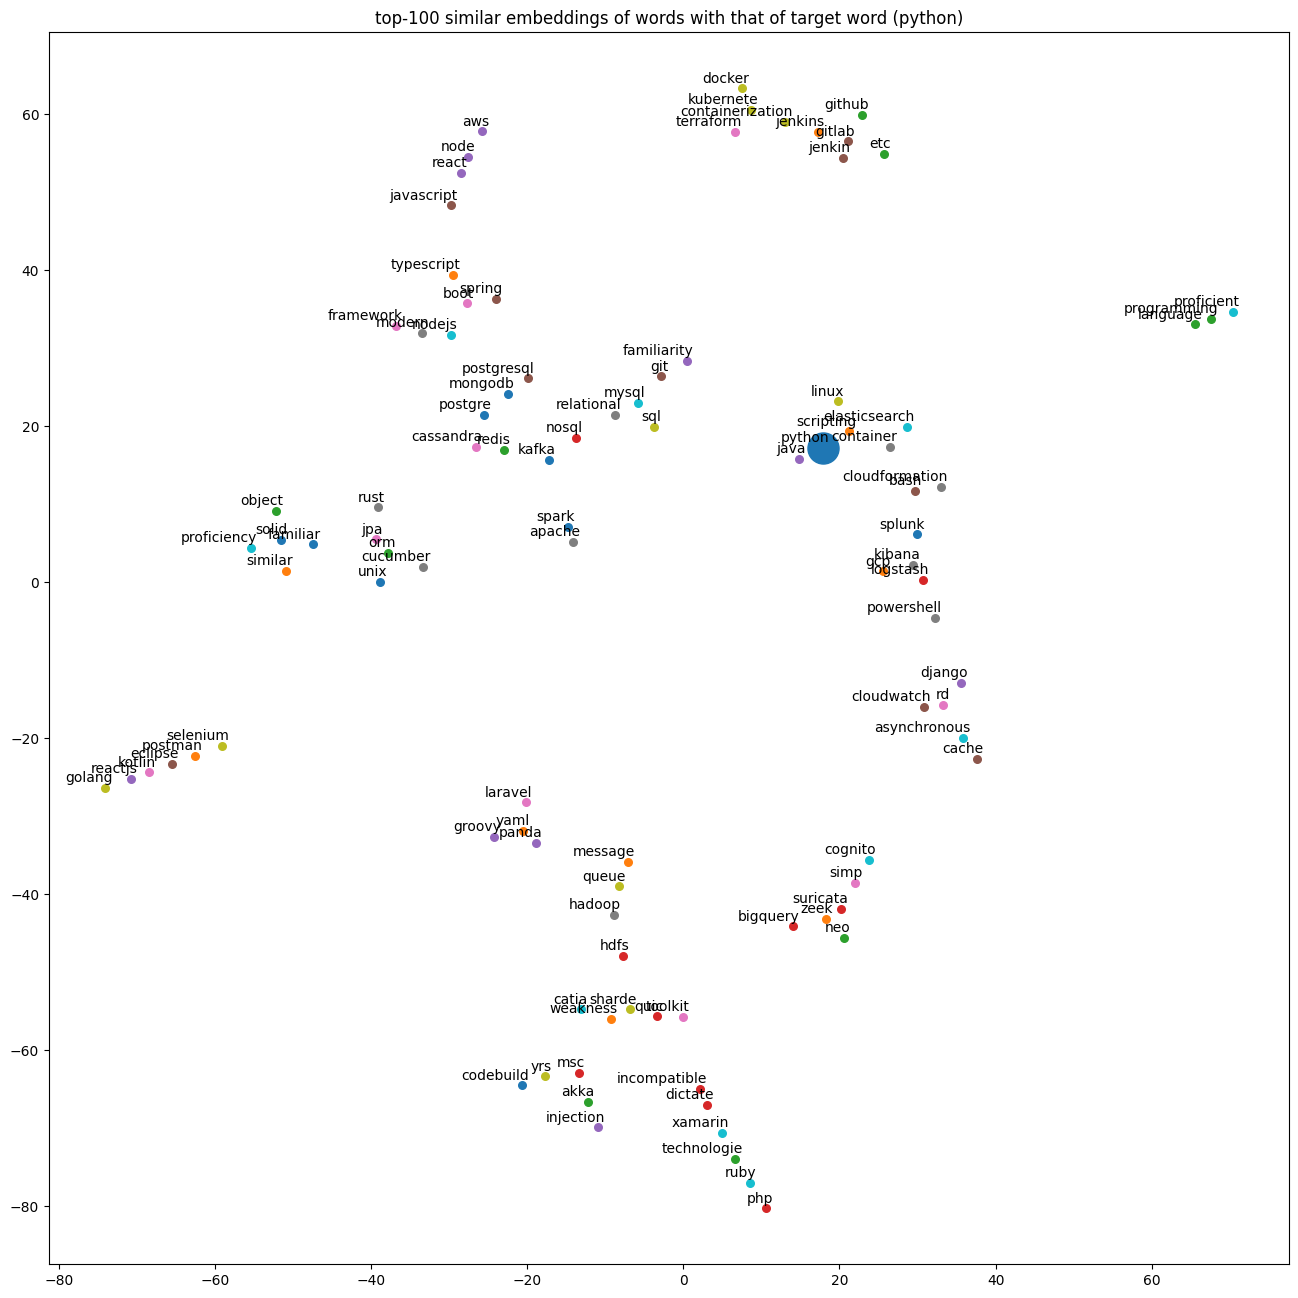

In [34]:
# Train Word2Vec model with more window size (5 -> 20)
model = Word2Vec(tokenized_descriptions, vector_size=100, window=20, min_count=1, workers=12)
trained_word_count, raw_word_count = model.train(tokenized_descriptions, total_examples=len(tokenized_descriptions), epochs=10)

k = 100
target_word = "python"
tsne_plot(model, target_word, k)

100%|██████████| 8375/8375 [00:00<00:00, 217855.86it/s]


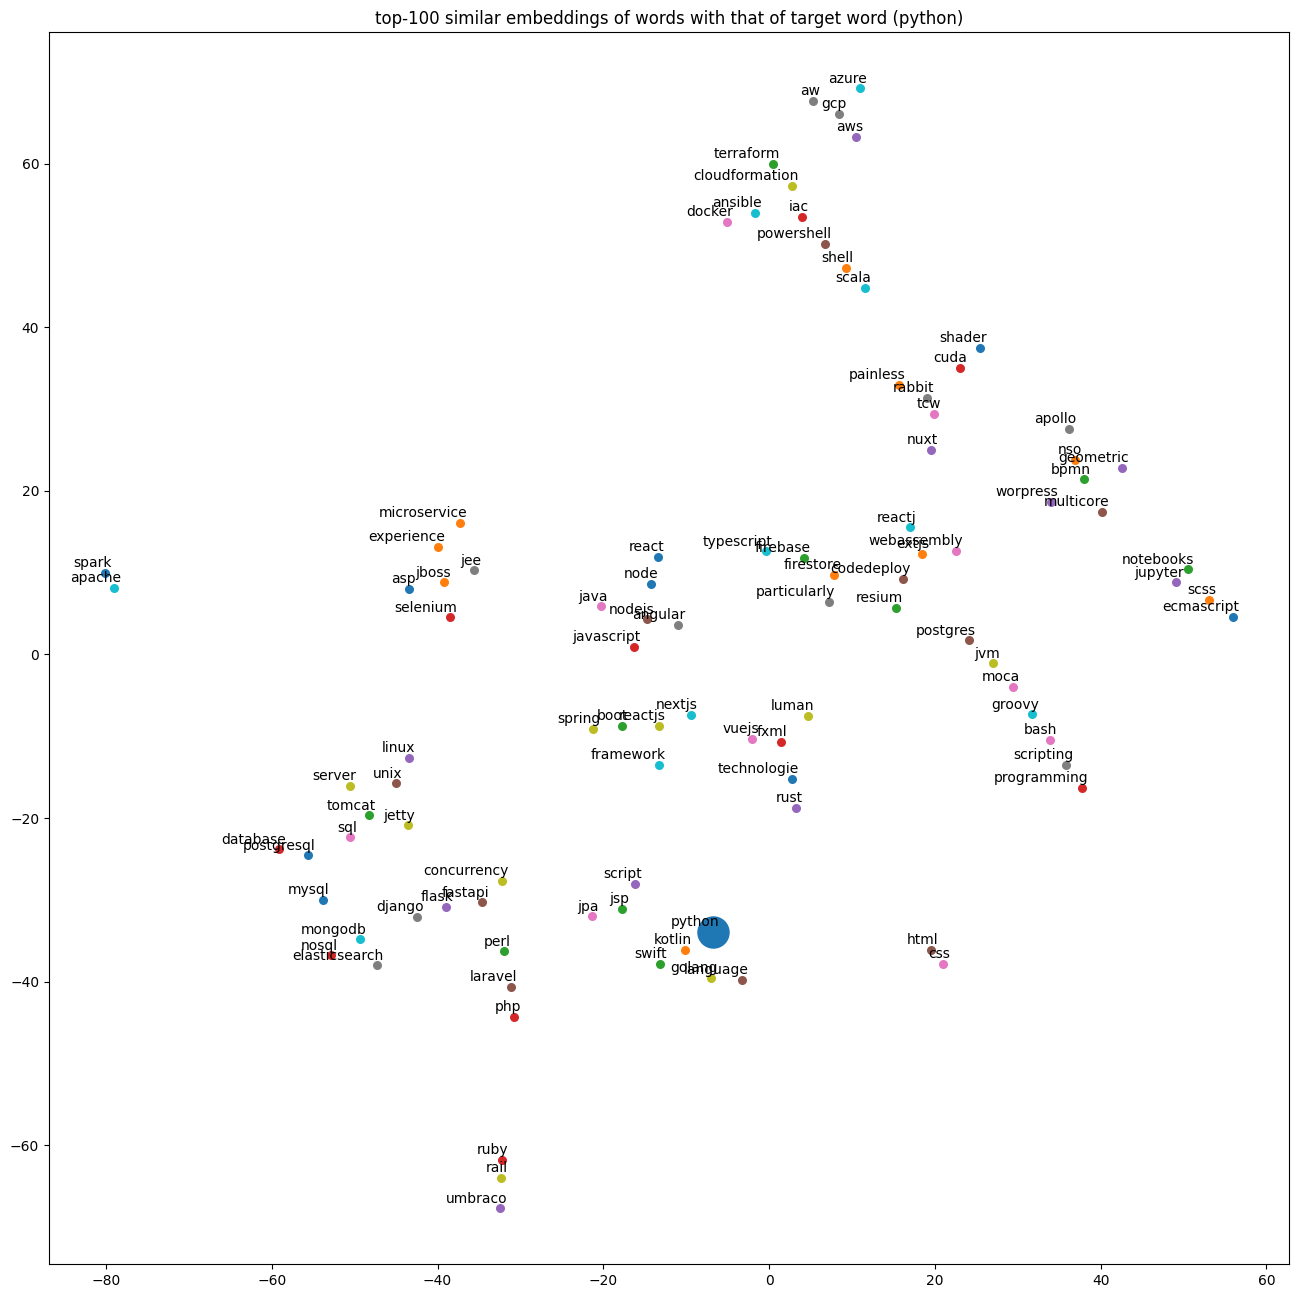

In [35]:
# Train Word2Vec model with more epochs (10 -> 50)
model = Word2Vec(tokenized_descriptions, vector_size=100, window=5, min_count=1, workers=12)
trained_word_count, raw_word_count = model.train(tokenized_descriptions, total_examples=len(tokenized_descriptions), epochs=50)

k = 100
target_word = "python"
tsne_plot(model, target_word, k)

It was hard to see overall difference among the hyperparameter sets but you can see some insightful difference locally around the word "python"  

1. increase word embedding size
Around the word "python", similar words didn't much.  
the words [java, proficient, language, script] are still the most closest words with the target word in embedding space.

2. increase window size
This change was interesting because size of window did affect the some of closest words around the target word.
e.g. container, elasticsearch and linux are not directly related with "python" but it would be in this large context. 

3. increase epochs
I found another interesting result in this change of hyper parameter; As I increase the epochs, it seems to learn more specific meaning of the target word. Specifically, the model figure out the meaning of "python" to be more "contemporary programming language". Therefore, I can see more high-level programming languages like swift, kotlin, golang.

## Application Section (Document similarity)

Calculate document embeddings:  
Simpliest method to compute document similarity from word embeddings would be to take average of these embeddings.

In [10]:
doc_embeddings = []
for tokens_in_doc in tokenized_descriptions:
    embedding = model.wv[tokens_in_doc[0]].copy()
    for token in tokens_in_doc[1:]:
        embedding += model.wv[token]
    embedding /= len(tokens_in_doc)
    doc_embeddings.append(embedding.reshape(1, -1))

Nature of the task (document similarity), it is hard to do quantitative assessment.
So let's see one job description example and it's the closest / furthest job description.

# 

In [18]:
# Target job description
index = 0
print(valid_descriptions[index])

**Job Description:**  
We are seeking a Hyperion Developer to join a team providing configuration and capability support services for project at the Pentagon in Washington, DC.

In this role you will be responsible for the overall design and deployment of the ERP application system architecture. An expert in various ERP related technologies and system architecture components and can serve as the overall technical lead of the program.

Specific tasks you will perform as a Hyperion Developer include, but are not limited to:

* Participate in the design, development, and implementation of new system functionality
* Will provide guidance on the best technologies for the project
* Provide technical support and troubleshooting to resolve system issues, ensuring optimal system performance and stability
* Analyzes requirements, procedures, and problems to automate processing and/or testing to help improve existing systems
* Drive continuous improvement initiatives to optimize system performanc

In [21]:
# Sorting the documents (job descriptions) based on the cosine similarity with the target document
target_embedding = doc_embeddings[index]
similarity = [cosine_similarity(target_embedding, doc_embedding).squeeze() for doc_embedding in doc_embeddings]
similar_docs = np.argsort(similarity)[::-1]

In [22]:
# The closest document
print(valid_descriptions[similar_docs[1]])

Creative Technology Solutions LLC is known for designing, developing, deploying and sustaining innovative technologies and business solutions that solve problems for Government and healthcare clients, and we need a new self-starter, problem-solver to take the reins. We’re seeking a highly skilled systems engineer (must be US Citizen) who has the business knowledge and technical expertise including software development experience to implement strategies, evaluate technologies, and build upon an infrastructure that supports the changing needs of our customers and their mission. In this role, the systems engineer will design, develop, and help integrate complex work systems for every stage of a lifecycle. The ideal candidate will be able to reliably deliver mission-critical solutions, provide clients’ with recommendations on best strategy to support their mission and support solutions for users that are optimized, secure and cost-effective.

**Objectives of this role**

* Manage and monit

In [23]:
# The furthest document 
print(valid_descriptions[similar_docs[-1]])

About the Position Foursquare is looking for a **Software** **Engineer** to join our team! While we would prefer candidates based in or around our office hubs in New York City, Chicago, Seattle, or San ...


The document embeddings appear to capture some of the high-level attributes from the job descriptions. This is evident from the fact that the target document and the closest document share similar tasks, such as designing or deploying software. However, there are additional attributes that do not seem to be shared between them, such as contract type (e.g., contract vs full-time) or specific skill sets required. Furthermore, it is misleading to consider the furthest document as the "furthest" document, as it lacks attributes related to the job rather than having opposite attributes.

## Discussion Section

Reflect on the strengths and weaknesses of Word2Vec. Discuss any limitations or challenges you encountered during the implementation and application of Word2Vec.

- strengths
  - Dense representation
    In comparison to TF-IDF or BagOfWords, word2vec provide dense representation of words as vector so that it can capture more rich information about each word.

  - Transfer Learning and fine-tunning
    these embeddings are trained a corpus of data and can be reused the model when you fine-tune this model with more domain specific data or the features (embeddings) for transfer-learning.

- Weaknesses
  - Lack of Contextual Understanding
    Word2Vec use fixed embeddings for each word. However, the same word can be interpreted as a different meaning based on the context before the word is said.